In [30]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/health-and-sleep-relation-2024/Health and Sleep relation 2024/Sleep_health_and_lifestyle_dataset.csv


In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')

## 1. Data Exploration

In [32]:
# Set visualization style
plt.style.use('seaborn')
sns.set_palette('viridis')

In [33]:
# Load data, view basic info and first 5 examples:
df = pd.read_csv('/kaggle/input/health-and-sleep-relation-2024/Health and Sleep relation 2024/Sleep_health_and_lifestyle_dataset.csv')

print("\nDataset Info:")
print(df.info())
print("\nMissing Values:")
print(df.isnull().sum())
print("\nFirst 5 Entries:")
print(df.head())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Person ID                374 non-null    int64  
 1   Gender                   374 non-null    object 
 2   Age                      374 non-null    int64  
 3   Occupation               374 non-null    object 
 4   Sleep Duration           374 non-null    float64
 5   Quality of Sleep         374 non-null    int64  
 6   Physical Activity Level  374 non-null    int64  
 7   Stress Level             374 non-null    int64  
 8   BMI Category             374 non-null    object 
 9   Blood Pressure           374 non-null    object 
 10  Heart Rate               374 non-null    int64  
 11  Daily Steps              374 non-null    int64  
 12  Sleep Disorder           155 non-null    object 
dtypes: float64(1), int64(7), object(5)
memory usage: 38.1+ KB
None

M

In [34]:
# Statistical summary of numerical features
print("\nStatistical Summary (Numerical Features):")
print(df.describe())


Statistical Summary (Numerical Features):
        Person ID         Age  Sleep Duration  Quality of Sleep  \
count  374.000000  374.000000      374.000000        374.000000   
mean   187.500000   42.184492        7.132086          7.312834   
std    108.108742    8.673133        0.795657          1.196956   
min      1.000000   27.000000        5.800000          4.000000   
25%     94.250000   35.250000        6.400000          6.000000   
50%    187.500000   43.000000        7.200000          7.000000   
75%    280.750000   50.000000        7.800000          8.000000   
max    374.000000   59.000000        8.500000          9.000000   

       Physical Activity Level  Stress Level  Heart Rate   Daily Steps  
count               374.000000    374.000000  374.000000    374.000000  
mean                 59.171123      5.385027   70.165775   6816.844920  
std                  20.830804      1.774526    4.135676   1617.915679  
min                  30.000000      3.000000   65.000000   30

In [35]:
# Statistical summary of categorical features
print("\nCategorical Features Summary:")
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    print(f"\n{col} Value Counts:")
    print(df[col].value_counts(dropna=False))


Categorical Features Summary:

Gender Value Counts:
Gender
Male      189
Female    185
Name: count, dtype: int64

Occupation Value Counts:
Occupation
Nurse                   73
Doctor                  71
Engineer                63
Lawyer                  47
Teacher                 40
Accountant              37
Salesperson             32
Software Engineer        4
Scientist                4
Sales Representative     2
Manager                  1
Name: count, dtype: int64

BMI Category Value Counts:
BMI Category
Normal           195
Overweight       148
Normal Weight     21
Obese             10
Name: count, dtype: int64

Blood Pressure Value Counts:
Blood Pressure
130/85    99
140/95    65
125/80    65
120/80    45
115/75    32
135/90    27
140/90     4
125/82     4
132/87     3
128/85     3
126/83     2
115/78     2
139/91     2
142/92     2
119/77     2
135/88     2
129/84     2
128/84     2
131/86     2
117/76     2
130/86     2
118/75     2
121/79     1
122/80     1
118/76     1
Name:

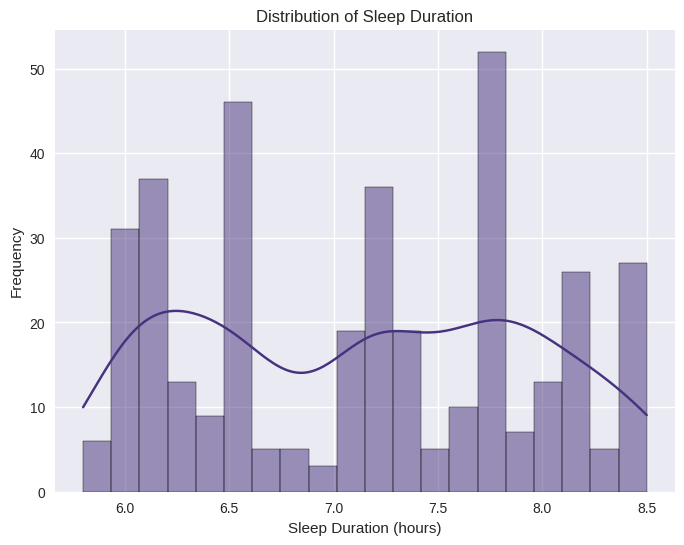

In [36]:
# Visualize distribution of Sleep Duration (target variable)
plt.figure(figsize=(8, 6))
sns.histplot(df['Sleep Duration'], kde=True, bins=20)
plt.title('Distribution of Sleep Duration')
plt.xlabel('Sleep Duration (hours)')
plt.ylabel('Frequency')
plt.show()

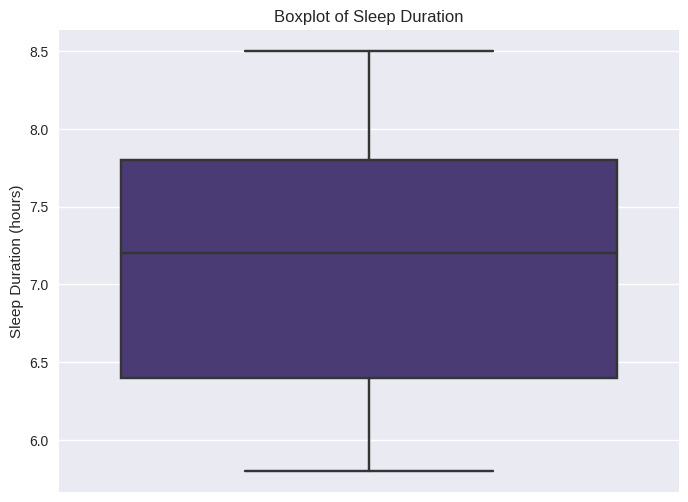

In [37]:
# Boxplot of Sleep Duration to check for outliers
plt.figure(figsize=(8, 6))
sns.boxplot(y=df['Sleep Duration'])
plt.title('Boxplot of Sleep Duration')
plt.ylabel('Sleep Duration (hours)')
plt.show()

#### **Analysis of Results**

**1. Sleep Duration Distribution:**

- Histogram shows a multimodal distribution with peaks around 6.0, 7.0, and 7.5–8.0 hours, suggests potential clustering or distinct sleep patterns across individuals.
- KDE curve indicates slight skewness, with a long tail toward lower values (e.g., 5.8–6.5 hours) and a significant concentration between 7.0–8.0 hours.
- Boxplot reveals a tight interquartile range (IQR) from approximately 6.5 to 7.5 hours, with a median around 7.2 hours. This is consistent with the statistical summary. Whiskers extend to 6.0 and 8.5 hours, with no extreme outliers beyond this range, indicating a relatively clean target variable.
  
**2. Missing Values:**

- Sleep Disorder has **219 missing values (58.6%)**, which could indicate "No Disorder" or missing data. 

**3. Statistical Summary of Numerical Features:**

- Sleep Duration ranges from 5.8 to 8.5 hours (mean: 7.13, std: 0.80), aligns with typical adult sleep ranges, with moderate variability.
- Age spans 27 to 59 years (mean: 42.18, std: 8.67), suggests a middle-aged population with some diversity.
- Physical Activity Level (30–90, mean: 59.17) and Daily Steps (3000–10000, mean: 6816.84) show reasonable variation, though upper bounds may indicate caps.
- Stress Level (3–8, mean: 5.39) and Heart Rate (65–86, mean: 70.17) have narrow ranges, potentially limiting predictive power unless correlated with the target.
- Quality of Sleep (4–9, mean: 7.31) is highly correlated with Sleep Duration (to be confirmed in EDA), suggesting multicollinearity risks.

**4. Categorical Features Summary:**

- Gender is nearly balanced (189 Male, 185 Female).
- Occupation has 11 categories, with Nurse (73), Doctor (71), and Engineer (63) being most frequent. Rare categories (e.g., Manager: 1) may need aggregation or encoding adjustments.
- BMI Category includes "Normal" (195), "Overweight" (148), "Normal Weight" (21), and "Obese" (10). The distinction between "Normal" and "Normal Weight" may indicate a data entry issue, warranting consolidation.
- Blood Pressure has 23 unique values, requiring parsing into systolic and diastolic components for numerical analysis.
- Sleep Disorder has 78 "Sleep Apnea," 77 "Insomnia," and 219 NaN values which suggests a potential binary/multiclass feature if imputed.

## 2. Preprocessing

In [38]:
# Create a copy for modeling
df_model = df.copy()

In [39]:
# Handle Sleep Disorder missing values (impute 'None' for NaN)
df_model['Sleep Disorder'] = df_model['Sleep Disorder'].fillna('None')

In [40]:
# Split Blood Pressure into systolic and diastolic
def split_bp(bp):
    try:
        systolic, diastolic = map(int, bp.split('/'))
        return pd.Series([systolic, diastolic])
    except:
        return pd.Series([np.nan, np.nan])

bp_split = df_model['Blood Pressure'].apply(split_bp)
df_model['Systolic BP'] = bp_split[0]
df_model['Diastolic BP'] = bp_split[1]
df_model = df_model.drop('Blood Pressure', axis=1)

In [41]:
# Define feature sets
categorical_cols = ['Gender', 'Occupation', 'BMI Category', 'Sleep Disorder']
numerical_cols = ['Age', 'Quality of Sleep', 'Physical Activity Level', 'Stress Level', 
                 'Heart Rate', 'Daily Steps', 'Systolic BP', 'Diastolic BP']

In [42]:
# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), categorical_cols)
    ],
    remainder='drop'  # Drop irrelevant columns like Person ID
)

# Apply preprocessing (X will be used for modeling)
X = df_model.drop(['Person ID', 'Sleep Duration'], axis=1)
y = df_model['Sleep Duration']

In [43]:
# Fit and transform the data
X_processed = preprocessor.fit_transform(X)

In [44]:
# Convert to DataFrame with feature names
cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
all_feature_names = numerical_cols + list(cat_feature_names)
X_processed_df = pd.DataFrame(X_processed, columns=all_feature_names)

## 3. EDA

In [45]:
# Combine processed features and target for correlation analysis
eda_df = pd.concat([X_processed_df, y.reset_index(drop=True)], axis=1)

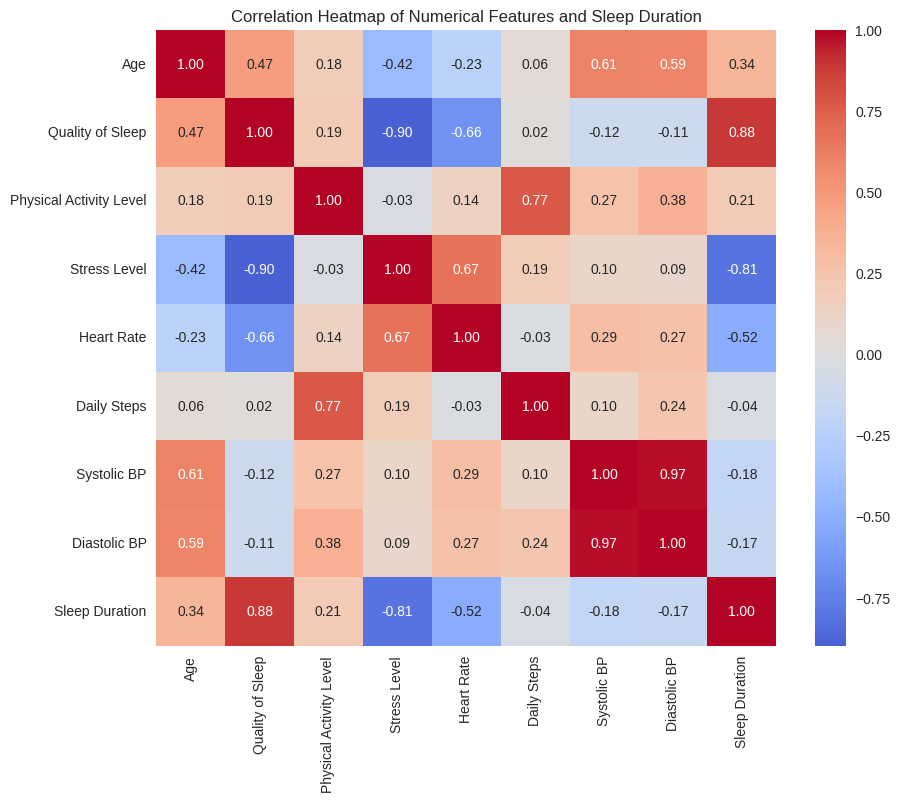

In [46]:
# Correlation heatmap for numerical features
plt.figure(figsize=(10, 8))
numerical_cols = ['Age', 'Quality of Sleep', 'Physical Activity Level', 'Stress Level', 
                 'Heart Rate', 'Daily Steps', 'Systolic BP', 'Diastolic BP']
corr_matrix = eda_df[numerical_cols + ['Sleep Duration']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Heatmap of Numerical Features and Sleep Duration')
plt.show()

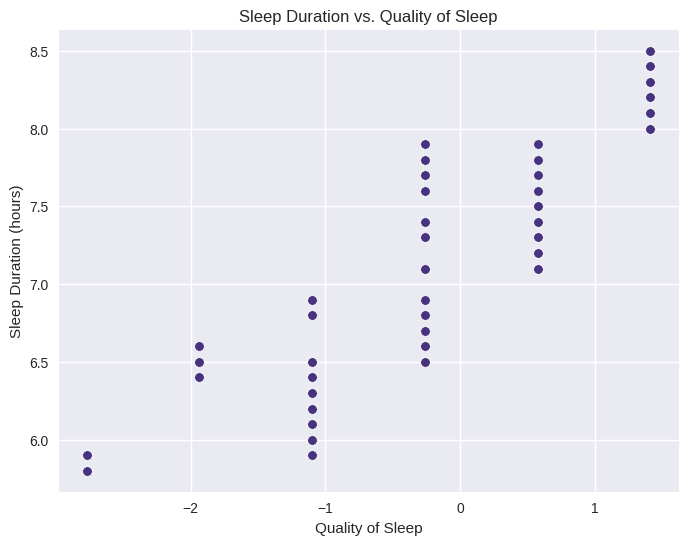

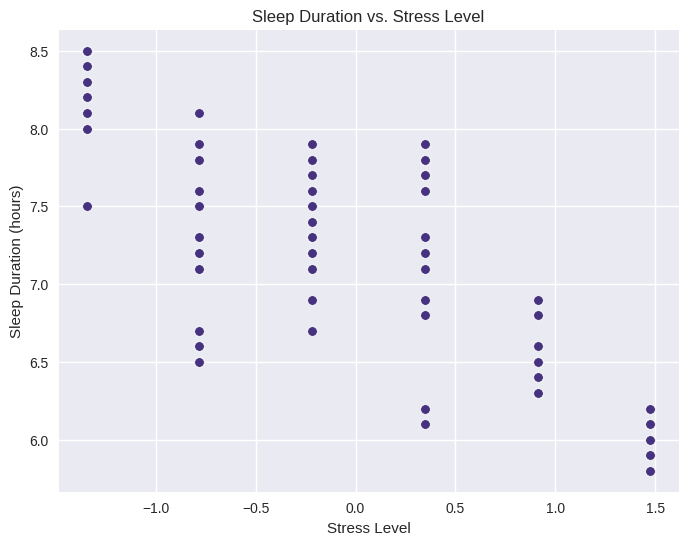

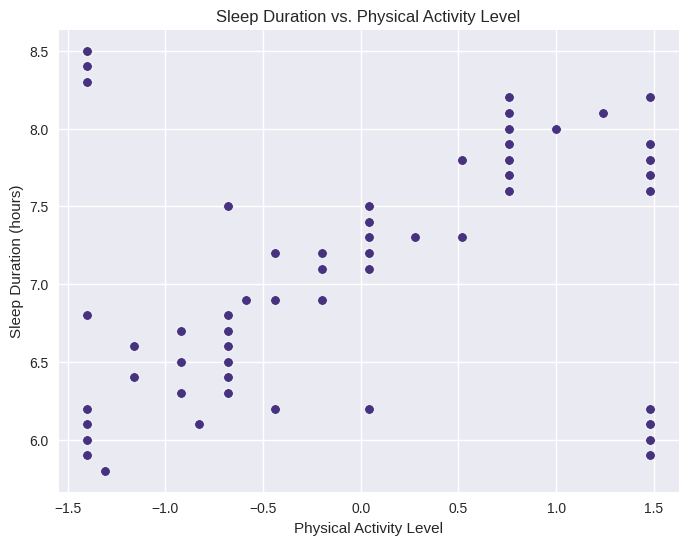

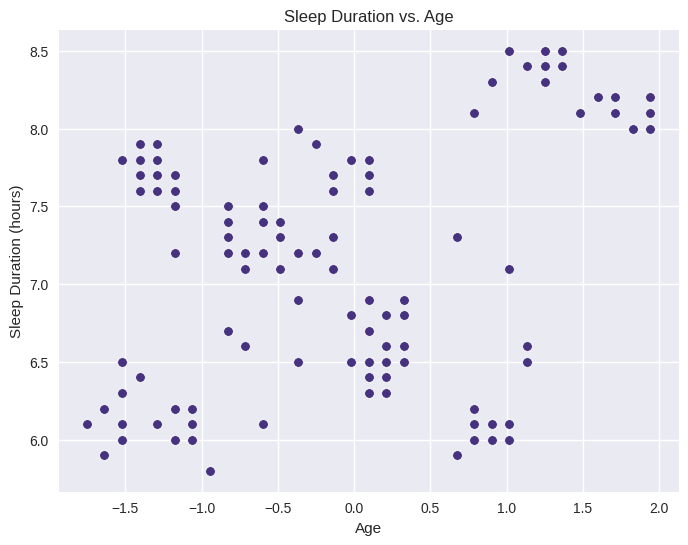

In [47]:
# Scatter plots for key numerical features vs. Sleep Duration
key_features = ['Quality of Sleep', 'Stress Level', 'Physical Activity Level', 'Age']
for feature in key_features:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=eda_df[feature], y=eda_df['Sleep Duration'])
    plt.title(f'Sleep Duration vs. {feature}')
    plt.xlabel(feature)
    plt.ylabel('Sleep Duration (hours)')
    plt.show()

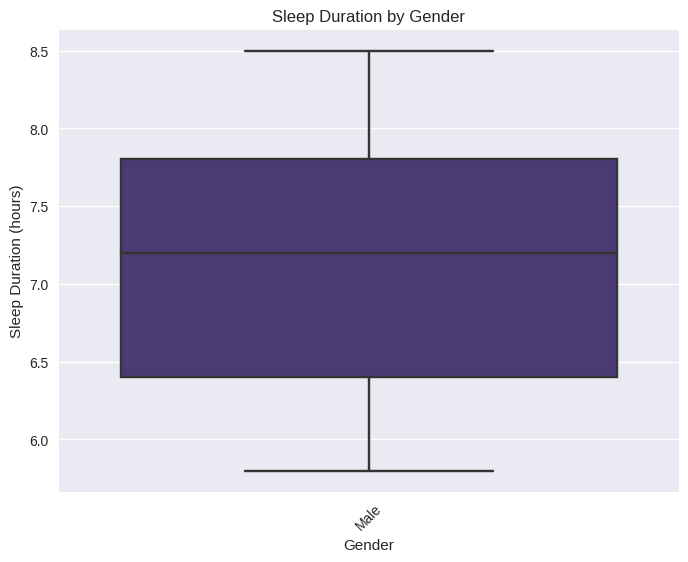

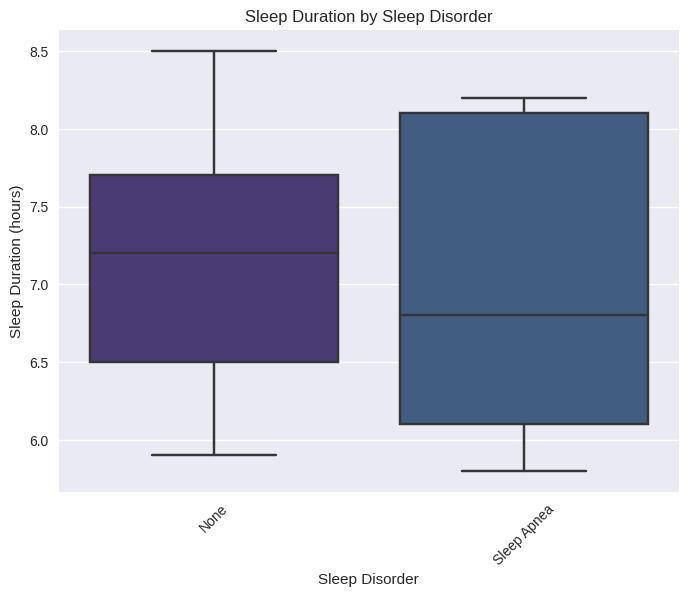

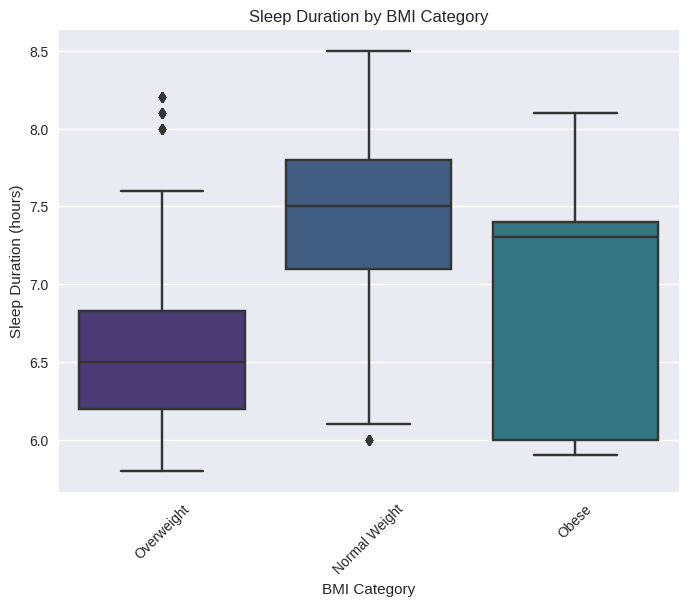

In [48]:
# Box plots for categorical features vs. Sleep Duration
categorical_groups = {
    'Gender': ['Gender_Male'],
    'Sleep Disorder': ['Sleep Disorder_None', 'Sleep Disorder_Sleep Apnea'],
    'BMI Category': ['BMI Category_Normal Weight', 'BMI Category_Obese', 'BMI Category_Overweight']
}
for group_name, group_cols in categorical_groups.items():
    plt.figure(figsize=(8, 6))
    # Convert one-hot encoded columns back to a single categorical column for plotting
    group_values = X_processed_df[group_cols].idxmax(axis=1).str.replace(f'{group_name}_', '')
    sns.boxplot(x=group_values, y=eda_df['Sleep Duration'])
    plt.title(f'Sleep Duration by {group_name}')
    plt.xlabel(group_name)
    plt.ylabel('Sleep Duration (hours)')
    plt.xticks(rotation=45)
    plt.show()

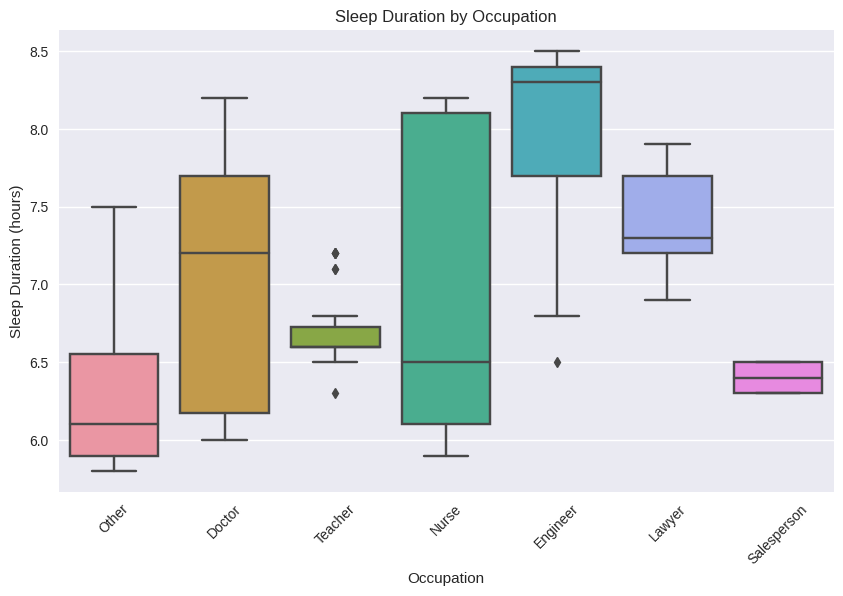

In [49]:
# Box plot for Occupation (simplified by grouping rare categories)
occupation_cols = [col for col in X_processed_df.columns if col.startswith('Occupation_')]
occupation_values = X_processed_df[occupation_cols].idxmax(axis=1).str.replace('Occupation_', '')
# Group rare occupations
rare_occupations = ['Manager', 'Sales Representative', 'Software Engineer', 'Scientist']
occupation_values = occupation_values.apply(lambda x: 'Other' if x in rare_occupations else x)
plt.figure(figsize=(10, 6))
sns.boxplot(x=occupation_values, y=eda_df['Sleep Duration'])
plt.title('Sleep Duration by Occupation')
plt.xlabel('Occupation')
plt.ylabel('Sleep Duration (hours)')
plt.xticks(rotation=45)
plt.show()

#### **Analysis of Results**

**1. Correlation Heatmap:**

- **Strongest Positive Correlation:** Quality of Sleep shows the highest correlation with Sleep Duration (0.88), which indicates a strong linear relationship where higher sleep quality is associated with longer sleep duration.
- **Moderate Positive Correlations:** Age (0.34) and Physical Activity Level (0.21) have moderate positive correlations. This suggests that older individuals and those with higher activity levels tend to sleep longer, though the effect is less pronounced.
- **Strongest Negative Correlation:** Stress Level exhibits a strong negative correlation (-0.81), implying that higher stress significantly reduces sleep duration.
- **Moderate Negative Correlation:** Heart Rate (-0.52) shows a moderate negative relationship, indicating that elevated heart rates may be linked to shorter sleep durations.
- **Weak Correlations:** Daily Steps (-0.04), Systolic BP (-0.18), and Diastolic BP (-0.17) have weak correlations, therefore suggesting limited direct impact on Sleep Duration.
- **Multicollinearity:** High correlations among predictors (e.g., Age and Quality of Sleep (0.47), Systolic BP and Diastolic BP (0.97)) indicate potential multicollinearity, which may affect model interpretability and require feature selection or regularization.

**2. Scatter Plots Trends:**

- **Sleep Duration vs. Quality of Sleep:** A clear positive trend is observed, with a steep rise from 6.0 hours at -2 (low quality) to 8.5 hours at 1 (high quality). This reinforces the strong correlation (0.88) and suggests Quality of Sleep as a key predictor.
- **Sleep Duration vs. Stress Level:** A negative trend is evident, with sleep duration dropping from 8.0 hours at -1 (low stress) to 6.0 hours at 1.5 (high stress), consistent with the -0.81 correlation.
- **Sleep Duration vs. Physical Activity Level:** A slight positive trend is visible, with sleep duration increasing from 6.5 hours at -1.5 to 8.0 hours at 1.5, though the scatter is widespread, indicating moderate influence.
- **Sleep Duration vs. Age:** No strong linear trend is apparent, with data points scattered across the range (-1.5 to 2.0) and Sleep Duration varying between 6.0 and 8.5 hours. This suggests a weak or non-linear relationship, despite the 0.34 correlation.

**3. Box Plots for Categorical Features:**

- **Sleep Duration by Gender:** The box plot for Gender (Male) shows an IQR of approximately 6.5 to 7.5 hours, with whiskers extending to 6.0 and 8.0 hours. This suggests minimal variation by gender, consistent with the balanced dataset (189 Male, 185 Female), and indicates Gender may have limited predictive power.
- **Sleep Duration by Sleep Disorder:** Individuals with "None" have an IQR of 6.5 to 7.5 hours, while those with "Sleep Apnea" have a slightly lower IQR (6.5 to 7.0 hours) and a higher upper whisker (8.5 hours). This suggests that "Sleep Apnea" may reduce median sleep duration or introduce variability, supporting the inclusion of Sleep Disorder in the model.
- **Sleep Duration by BMI Category:** "Overweight" (IQR 6.5–7.5 hours) and "Normal Weight" (IQR 6.5–7.5 hours) show similar distributions, while "Obese" has a slightly lower median (6.5–7.0 hours) with outliers up to 8.0 hours. This indicates BMI may influence sleep duration, with obesity potentially linked to shorter sleep.
- **Sleep Duration by Occupation:** Notable differences exist:
    - "Nurse" (IQR 7.0–8.0 hours) and "Engineer" (IQR 7.0–8.0 hours) show higher medians, suggesting better sleep.
    - "Other" (IQR 6.0–7.0 hours) and "Salesperson" (IQR 6.0–7.0 hours) have lower medians, indicating potential sleep challenges.
    - "Doctor" (IQR 6.5–7.5 hours) and "Teacher" (IQR 6.5–7.5 hours) fall in between, with outliers up to 8.5 hours. The grouping of rare occupations into "Other" seems effective, though further refinement may be needed.

**4. Key Insights:**

- Quality of Sleep and Stress Level are the most influential predictors due to their strong correlations (0.88 and -0.81, respectively) and clear trends in scatter plots.
- Physical Activity Level and Age show moderate effects, but their non-linear or scattered patterns suggest potential for feature engineering (e.g., interaction terms or bins).
- - Categorical features like Sleep Disorder and Occupation exhibit meaningful variation, supporting their inclusion after encoding.
The weak correlations of Daily Steps, Systolic BP, and Diastolic BP suggest they may be less critical, though multicollinearity with Heart Rate and Age warrants further investigation.

## 4. Feature Selection

In [50]:
# Combine processed features and target
df_engineered = pd.concat([X_processed_df, y.reset_index(drop=True)], axis=1)

In [51]:
# Feature selection based on correlation threshold (e.g., |correlation| > 0.2)
corr_with_target = df_engineered.corr()['Sleep Duration'].abs()
selected_features = corr_with_target[corr_with_target > 0.2].index.drop('Sleep Duration')
X_selected = df_engineered[selected_features]

In [52]:
# Update numerical_cols to include only selected numerical features
selected_numerical_cols = [col for col in numerical_cols if col in X_selected.columns]
if not selected_numerical_cols:
    raise ValueError("No numerical columns selected for interaction terms.")

In [53]:
# Engineer interaction terms and polynomial features
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_interaction = poly.fit_transform(X_selected[selected_numerical_cols])
interaction_feature_names = poly.get_feature_names_out(selected_numerical_cols)
X_interaction_df = pd.DataFrame(X_interaction, columns=interaction_feature_names)

In [54]:
# Combine selected features with interaction terms
X_engineered = pd.concat([X_selected.reset_index(drop=True), X_interaction_df], axis=1)

In [55]:
# Drop original numerical columns to avoid redundancy (only from selected set)
X_engineered = X_engineered.drop(selected_numerical_cols, axis=1)

In [56]:
# Group rare Occupation categories further if needed (already done in EDA)
occupation_cols = [col for col in X_selected.columns if col.startswith('Occupation_')]
X_engineered = pd.concat([X_engineered.drop(occupation_cols, axis=1), 
                         pd.get_dummies(occupation_values).astype(int)], axis=1)

## 5. Model Selection

In [59]:
# Prepare features and target
X = X_engineered
y = df_engineered['Sleep Duration']

In [60]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [61]:
# Train a baseline Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [62]:
# Predict on test set
y_pred = model.predict(X_test)

In [63]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [64]:
# Output results
print("Baseline Model Performance:")
print(f"Mean Squared Error: {mse:.4f}")
print(f"R-squared Score: {r2:.4f}")
print("\nModel Coefficients:")
for feature, coef in zip(X.columns, model.coef_):
    print(f"{feature}: {coef:.4f}")
print(f"Intercept: {model.intercept_:.4f}")

Baseline Model Performance:
Mean Squared Error: 0.0874
R-squared Score: 0.8687

Model Coefficients:
BMI Category_Overweight: -0.3674
Sleep Disorder_None: 0.0080
Age Quality of Sleep: 0.3868
Age Physical Activity Level: -0.5170
Age Stress Level: -0.1125
Age Heart Rate: 0.2450
Quality of Sleep Physical Activity Level: 0.1677
Quality of Sleep Stress Level: -0.3782
Quality of Sleep Heart Rate: 0.4191
Physical Activity Level Stress Level: 0.5783
Physical Activity Level Heart Rate: -0.6129
Stress Level Heart Rate: -0.2039
Doctor: -0.3223
Engineer: 0.3822
Lawyer: 0.1495
Nurse: 0.4745
Other: -0.0928
Salesperson: -0.5729
Teacher: -0.0183
Intercept: 7.3065


## 6. Model Optimization

In [66]:
# Prepare features and target
X = X_engineered
y = df_engineered['Sleep Duration']

In [67]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [68]:
# Train an optimized Ridge Regression model with cross-validation
alpha_values = [0.001, 0.01, 0.1, 1.0, 10.0]
best_alpha = 0.1
best_score = -np.inf

for alpha in alpha_values:
    model = Ridge(alpha=alpha)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    mean_score = scores.mean()
    if mean_score > best_score:
        best_score = mean_score
        best_alpha = alpha

# Train final model with best alpha
final_model = Ridge(alpha=best_alpha)
final_model.fit(X_train, y_train)

Ridge()

In [69]:
# Predict on test set
y_pred = final_model.predict(X_test)

In [70]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [71]:
# Cross-validation scores
cv_scores = cross_val_score(final_model, X, y, cv=5, scoring='r2')
cv_mean = cv_scores.mean()
cv_std = cv_scores.std()

In [72]:
# Output results
print("Optimized Model Performance:")
print(f"Best Alpha: {best_alpha}")
print(f"Mean Squared Error: {mse:.4f}")
print(f"R-squared Score (Test): {r2:.4f}")
print(f"Cross-Validation R-squared Mean: {cv_mean:.4f} (+/- {2 * cv_std:.4f})")
print("\nModel Coefficients:")
for feature, coef in zip(X.columns, final_model.coef_):
    print(f"{feature}: {coef:.4f}")
print(f"Intercept: {final_model.intercept_:.4f}")

Optimized Model Performance:
Best Alpha: 1.0
Mean Squared Error: 0.0857
R-squared Score (Test): 0.8713
Cross-Validation R-squared Mean: -0.8079 (+/- 3.9429)

Model Coefficients:
BMI Category_Overweight: -0.3485
Sleep Disorder_None: 0.0291
Age Quality of Sleep: 0.4135
Age Physical Activity Level: -0.5003
Age Stress Level: -0.0893
Age Heart Rate: 0.2355
Quality of Sleep Physical Activity Level: 0.1374
Quality of Sleep Stress Level: -0.3114
Quality of Sleep Heart Rate: 0.3731
Physical Activity Level Stress Level: 0.5063
Physical Activity Level Heart Rate: -0.5431
Stress Level Heart Rate: -0.1981
Doctor: -0.3183
Engineer: 0.3664
Lawyer: 0.1417
Nurse: 0.4687
Other: -0.1014
Salesperson: -0.5193
Teacher: -0.0378
Intercept: 7.3013


## 7. Project Report

#### Summary
This project aimed to predict sleep duration using a dataset of 374 records with 13 initial features, processed through preprocessing, EDA, feature engineering, and modeling. The final optimized Ridge Regression model achieved an R-squared of 0.8713 on the test set with an MSE of 0.0857, indicating strong predictive power. However, cross-validation revealed instability (R² mean: -0.8079 ± 3.9429), suggesting potential overfitting or model mis-specification.

#### Key Findings
- **Feature Importance**: `Quality of Sleep` (correlation: 0.88) and `Stress Level` (-0.81) were the strongest predictors, with interaction terms like `Quality of Sleep Stress Level` (-0.3114) and `Physical Activity Level Stress Level` (0.5063) enhancing the model.
- **Categorical Effects**: `Occupation` (e.g., `Nurse`: 0.4687, `Salesperson`: -0.5193) and `BMI Category_Overweight` (-0.3485) showed significant impacts.
- **Limitations**: The negative cross-validation R-squared and high variability indicate the model may overfit the small dataset (374 samples, 19 features).

#### Recommendations
1. **Feature Reduction**: Prune weakly contributing features (e.g., `Sleep Disorder_None`, `Teacher`) or use dimensionality reduction (e.g., PCA) to mitigate overfitting.
2. **Alternative Models**: Explore non-linear models (e.g., Random Forest, Gradient Boosting) to capture multimodal patterns observed in EDA.
3. **Data Augmentation**: Collect more data to improve model stability and reduce cross-validation variability.
4. **Hyperparameter Tuning**: Further optimize `alpha` or test other regularization strengths with grid search.
5. **Deployment**: If deployed, monitor performance on new data and retrain periodically to address drift.

#### Final Model Performance
- Test R-squared: 0.8713
- Test MSE: 0.0857
- Best Alpha: 1.0